In [47]:
# preparations
import cv2
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from fundamental_matrix import RansacModel, Camera, F_from_ransac, compute_P_from_essential, triangulate, kpsObjToArray, findNeighbours, plotMatches

from hw3_defs import normalize_images, grayscale_images, find_features, get_matches, get_all_matches


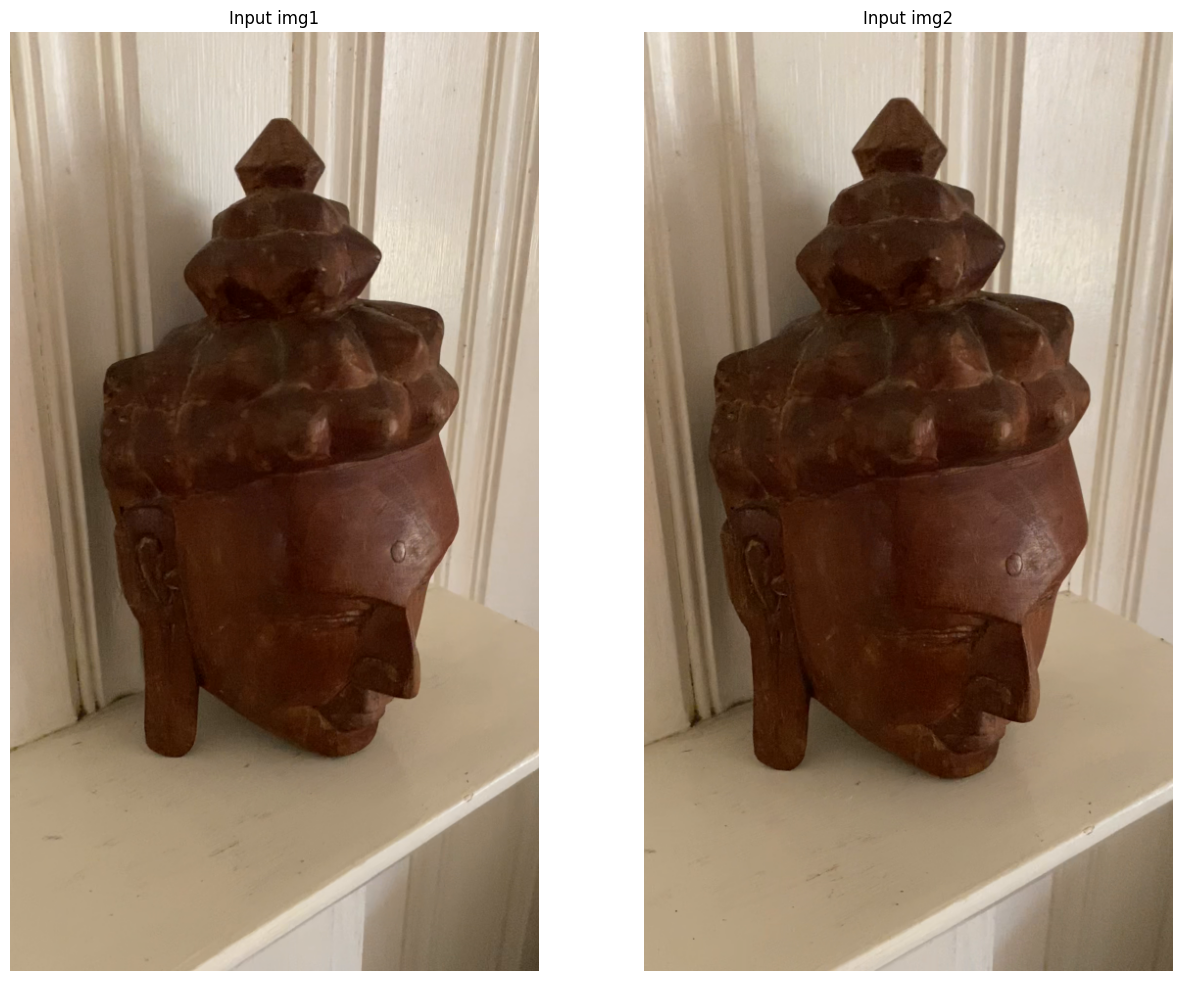

In [48]:
# Read images
img1 = cv2.cvtColor(cv2.imread("buddha_images/buddha_005.png"),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("buddha_images/buddha_006.png"),cv2.COLOR_BGR2RGB)

# Resize images to half of the original
scale_factor = 0.5
newshape = (int(img1.shape[0] * scale_factor),int(img1.shape[1] * scale_factor))
im1_ = resize(img1, newshape) * 255. # output of resize is double [0,1]
im2_ = resize(img2, newshape) * 255.
im1_ = im1_.astype(np.uint8) # needs to be uint8 for opencv sift 
im2_ = im2_.astype(np.uint8)

img_h = img1.shape[1]
img_w = img1.shape[0]
# Camera intrinsics
K = np.array([[img_w, 0, img_w/2],
            [0, img_w, img_h/2],
            [0,0,1]])

# Update camera intrinsics
s = np.array([[scale_factor, 0, 0], [0, scale_factor, 0], [0, 0, 1]])
K = np.dot(s, K)

# Plot input images
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax = axis.ravel()
ax[0].imshow(im1_)
ax[0].set_title("Input img1")
ax[0].axis('off')
ax[1].imshow(im2_)
ax[1].set_title("Input img2")
ax[1].axis('off')
plt.show()

In [49]:
# Same Hyperparameter settings as HW3
sift = cv2.SIFT_create(nfeatures=5000, nOctaveLayers=16, contrastThreshold=0.025, edgeThreshold=10, sigma=1.4)

kp, des, imgs_sift = find_features(sift, [im1_, im2_])

ptsList, goodMatchList = get_all_matches(kp, des, print_matches=False)

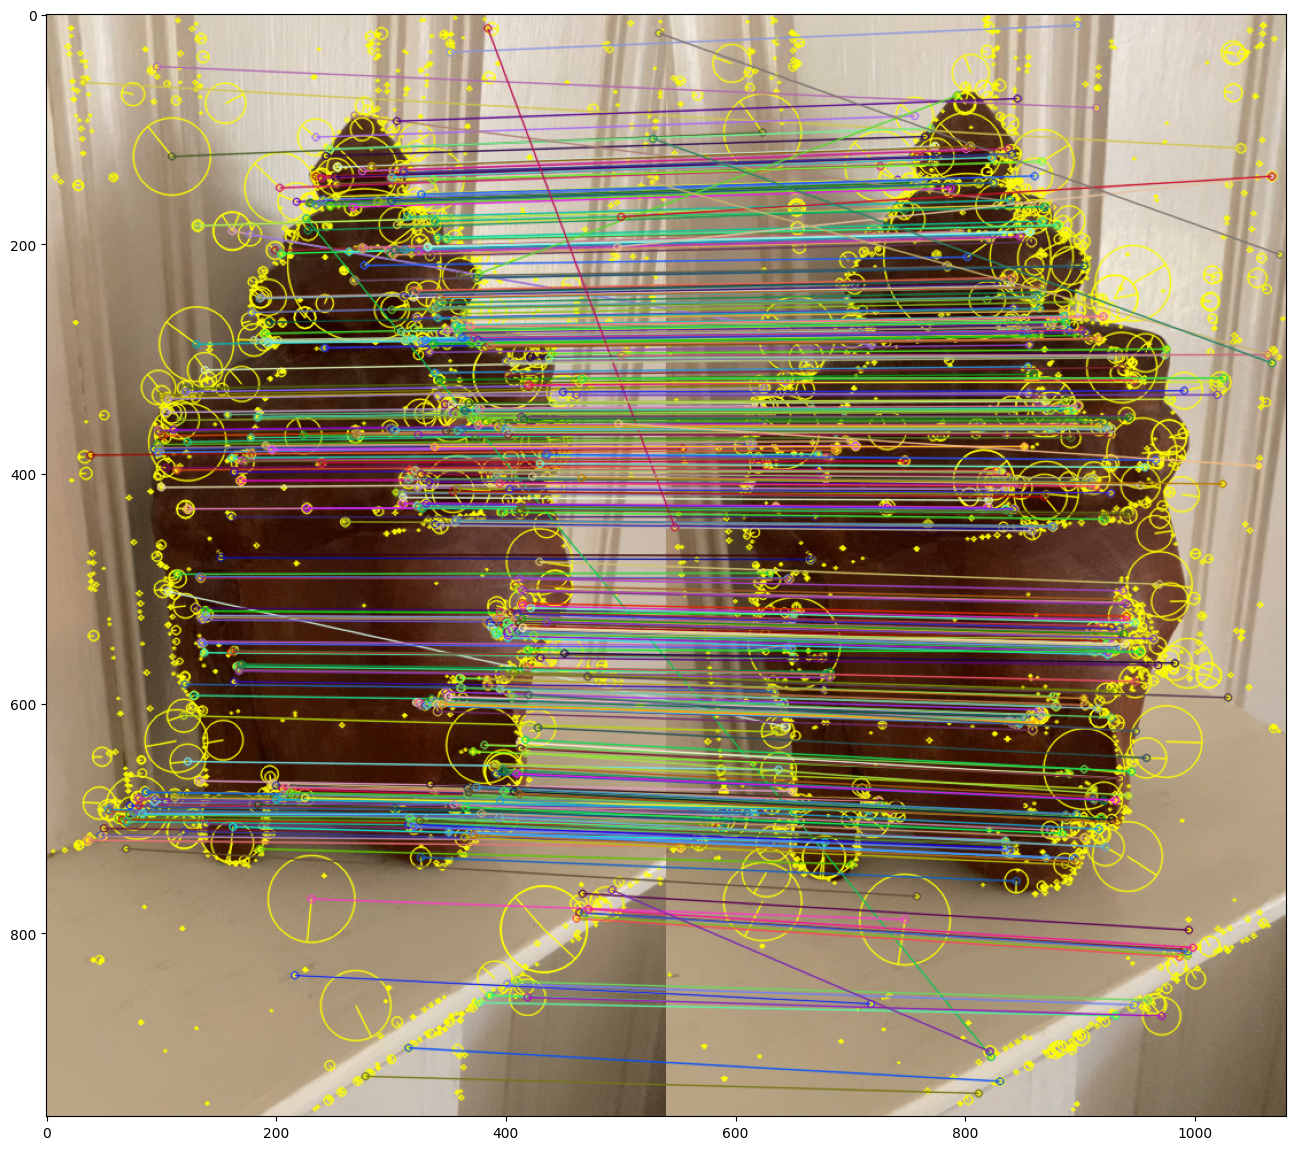

(<matplotlib.image.AxesImage at 0x7f854c574820>, None)

In [50]:
img3 = cv2.drawMatches(im1_,kp[0],im2_,kp[1],goodMatchList[0],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (16,16))
plt.imshow(img3),plt.show()

In [51]:
kps1 = kpsObjToArray(kp[0])
kps2 = kpsObjToArray(kp[1])

In [52]:
print(ptsList[0][0].shape)
x1 = np.hstack((ptsList[0][0], np.ones((ptsList[0][0].shape[0],1))))
x2 = np.hstack((ptsList[0][1], np.ones((ptsList[0][1].shape[0],1))))

# Normalized coordinates
x1n = np.dot(np.linalg.inv(K),x1.T)
x2n = np.dot(np.linalg.inv(K),x2.T)

model = RansacModel()
E,inliers = F_from_ransac(x1n,x2n,model)

(491, 2)


In [53]:
# compute camera matrices (P2 will be list of four solutions)
P1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P2 = compute_P_from_essential(E)

# pick the solution with points in front of cameras
ind = 0
maxres = 0
for i in range(4):
    # triangulate inliers and compute depth for each camera
    X = triangulate(x1n[:,inliers],x2n[:,inliers],P1,P2[i])
    d1 = np.dot(P1,X)[2]
    d2 = np.dot(P2[i],X)[2]
    if sum(d1>0)+sum(d2>0) > maxres:
        maxres = sum(d1>0)+sum(d2>0)
        ind = i
        infront = (d1>0) & (d2>0)
# triangulate inliers and remove points not in front of both cameras
X = triangulate(x1n[:,inliers],x2n[:,inliers],P1,P2[ind])
X = X[:,infront]

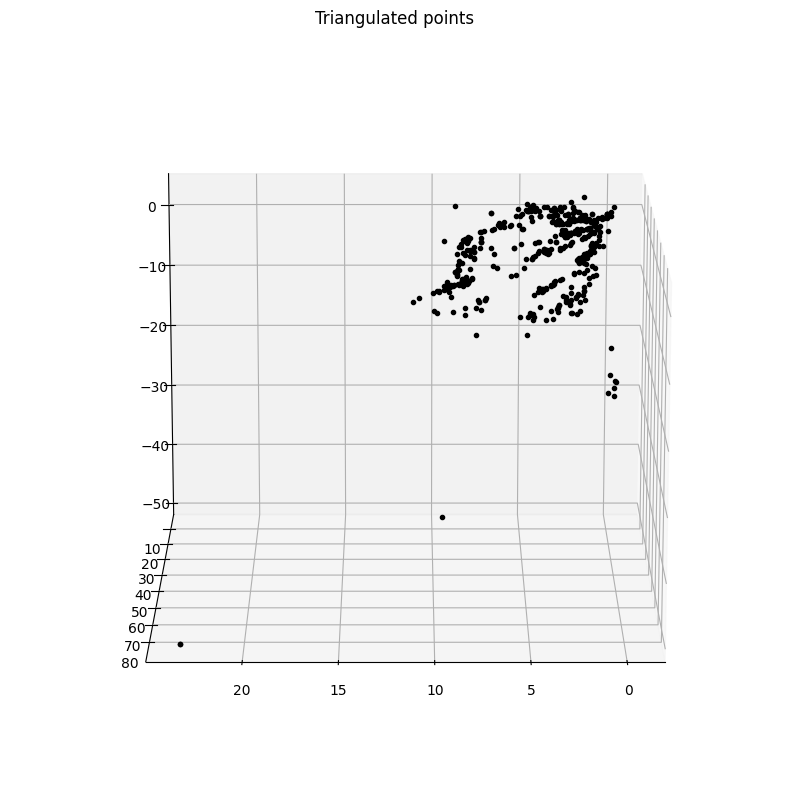

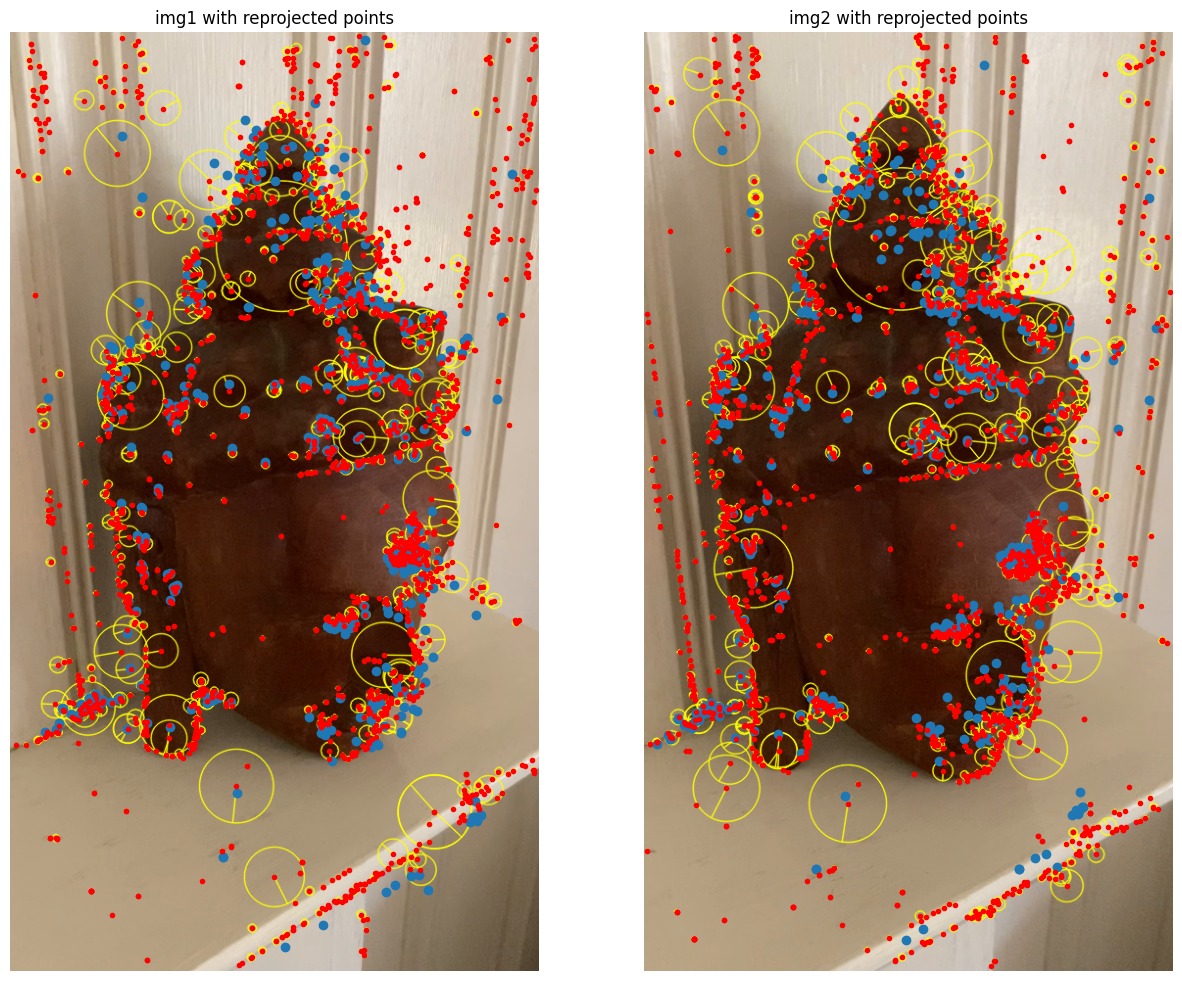

In [72]:
# 3D plot
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot(-X[0],X[2],-X[1],'k.')
ax.set_title("Triangulated points")
# rotate the axes to better show the point cloud
ax.view_init(elev=15, azim=90)

# project 3D points
cam1 = Camera(P1)
cam2 = Camera(P2[ind])
x1p = cam1.project(X)
x2p = cam2.project(X)

# reverse K normalization
x1p = np.dot(K,x1p)
x2p = np.dot(K,x2p)

# Plot input images
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax = axis.ravel()
ax[0].imshow(im1_)
ax[0].plot(x1p[0],x1p[1],'o')
ax[0].plot(kps1[:,0],kps1[:,1],'r.')
ax[0].set_title("img1 with reprojected points")
ax[0].axis('off')

ax[1].imshow(im2_)
ax[1].plot(x2p[0],x2p[1],'o')
ax[1].plot(kps2[:,0],kps2[:,1],'r.')
ax[1].set_title("img2 with reprojected points")
ax[1].axis('off')

plt.show()